In [3]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

In [8]:
atomic_w_repetitions = []
dirs = []
base_dir = "../data/"
projects = ["ffmpeg", "qemu"]
all_commits = []
for project in projects: 
    project_path = os.path.join(base_dir, project)
    dirs = [d for d in os.listdir(project_path) if os.path.isdir(os.path.join(project_path, d))]
    for commit in dirs:
        all_commits.append(commit)
        commit_path = os.path.join(project_path, commit)
        commit_files = [f for f in os.listdir(commit_path) if os.path.isfile(os.path.join(commit_path, f))]
        if "conclusion" in commit_files:
            with open(os.path.join(commit_path, "conclusion"), "r") as rfi:
                for line in rfi: 
                    if line.strip() == "atomic with repetitions":
                        atomic_w_repetitions.append(commit)

In [5]:
commit_targets_path = "objects/commit_to_targets.pkl"

if not os.path.isfile(commit_targets_path): 
    commit_to_targets = {}
    for data in devign_full_graph:
        split_data = data['file_name'].split("_")
        commit = split_data[2]
        target = data["targets"][0][0]
        if commit in commit_to_targets.keys(): 
            commit_to_targets[commit].append(target)
        else:
            commit_to_targets[commit] = [target]

    pickle.dump(commit_to_targets, open(commit_targets_path, "wb"))
else:
    commit_to_targets = pickle.load(open(commit_targets_path, "rb"))

In [10]:
total_complex = 0
total = 0
total_functions = 0 
total_complex_functions = 0
bar_plot_data = {}
for commit, target in commit_to_targets.items():
    functions = len(target)
    if target[0] == 1:
        if len(target) > 1:
            total_complex += 1
            total_complex_functions += len(target)
        total += 1
        total_functions += len(target)
        if commit[:7] in atomic_w_repetitions: 
            if 1 in bar_plot_data.keys(): 
                bar_plot_data[1] += len(target)
            else:
                bar_plot_data[1] = len(target)
        else:
            if functions in bar_plot_data.keys():
                bar_plot_data[functions] += 1
            else: 
                bar_plot_data[functions] = 1

In [16]:
def plot_data(dict_obj, base_unit):
    x_axis = list(dict_obj.keys())
    x_axis.sort()
    y_axis = [dict_obj[x] for x in x_axis]
    x_labels = []
    for x in x_axis:
        if x == 10:
            x = "10+"
        x_labels.append(str(x))
    fig = plt.figure(figsize = (5, 4))
    plt.bar (x_labels, y_axis, width = 0.4, color = 'maroon')
    plt.xlabel(f"Number of {base_unit}")
    plt.ylabel(f"Number of vulnerabilities")
    plt.title("Distribution of vulnerabilities")

In [17]:
bar_plot_data_processed = {}
total = 0
complex_vulns = 0
for key, items in bar_plot_data.items():
    if key >= 10: 
        key = 10
    if key in bar_plot_data_processed.keys(): 
        bar_plot_data_processed[key] += items
    else:
        bar_plot_data_processed[key] = items
    total += items
    if key > 1:
        complex_vulns += items

In [18]:
bar_plot_data_processed

{1: 5191, 2: 614, 10: 103, 7: 44, 4: 147, 3: 271, 8: 29, 6: 59, 5: 87, 9: 23}

In [19]:
plot_data(bar_plot_data_processed, "functions")

In [20]:
complex_vulns / total

0.20965286236297198

In [26]:
overlaps = []
for prediction_dict in commit_vuln_predictions_30_runs: 
    overlap = 0
    for commit, results in prediction_dict.items():
        if commit not in commit_to_targets.keys():
            continue
        if commit_to_targets[commit][0]==1:
            if len(results) < len(commit_to_targets[commit]):
                overlap += 1
    overlaps.append(overlap)

In [4]:
commit_vuln_predictions_30_runs = pickle.load(open("objects/commit_vuln_predictions_30_runs.pkl", "rb"))

In [5]:
correctness = []
for prediction_dict in commit_vuln_predictions_30_runs: 
    total_correct = 0
    total_no_of_vuln = 0 
    for commit, values in prediction_dict.items():
        for value in values: 
            if value == 1: 
                total_correct += 1
        total_no_of_vuln += len(values)
    if total_no_of_vuln == 0:
        correctness.append("N/A")
    else:
        correctness.append(total_correct/total_no_of_vuln)

In [6]:
correctness

[0.9299725382502942,
 'N/A',
 0.954099646920361,
 'N/A',
 0.7985484503726952,
 0.8313063946645743,
 0.8112985484503727,
 0.7683405256963515,
 'N/A',
 0.7355825814044723,
 'N/A',
 0.8983915260886622,
 0.7765790506080816,
 0.8742644174185955,
 'N/A',
 0.7910945468811299,
 'N/A',
 'N/A',
 'N/A',
 0.8216947822675559,
 0.8872106708513142,
 'N/A',
 0.7508826990976853,
 0.7965868968222832,
 0.8540604158493527,
 0.8009023146331895,
 'N/A',
 0.9138877991369164,
 'N/A',
 'N/A']

In [29]:
import statistics
statistics.median(f for f in correctness if f != "N/A")



0.8164966653589643

In [30]:
statistics.mean(f for f in correctness if f != "N/A")

0.8330391003007716

In [31]:
statistics.stdev(f for f in correctness if f != "N/A")

0.0639260163723685

In [32]:
correctness_adjusted = []
for prediction_dict in commit_vuln_predictions_30_runs: 
    total_correct = 0
    total_no_of_vuln = 0 
    atomic_w_repetitions_count = 0
    for commit, values in prediction_dict.items():
        if commit[:7] in atomic_w_repetitions:
            for value in values: 
                if value == 1: 
                    total_correct += 1
                    total_no_of_vuln += 1
        else:
            total_correct = total_correct + 1 if 0 not in values else total_correct
            total_no_of_vuln += 1
    if total_no_of_vuln == 0:
        correctness_adjusted.append("N/A")
    else:
        correctness_adjusted.append(total_correct/total_no_of_vuln)

In [33]:
statistics.median(f for f in correctness_adjusted if f != "N/A")


0.7811886346771613

In [34]:
statistics.mean(f for f in correctness_adjusted if f != "N/A")


0.7987956475425141

In [35]:
statistics.stdev(f for f in correctness_adjusted if f != "N/A")

0.07203324663975612

In [36]:
atomic_commits = []
correctness_adjusted_atomic = []
i = 0
for prediction_dict in commit_vuln_predictions_30_runs: 
    total_correct = 0
    total_no_of_vuln = 0 
    for commit, values in prediction_dict.items():
        if len(values) == 1 or commit[:7] in atomic_w_repetitions: 
            for value in values: 
                if value == 1: 
                    total_correct += 1
            total_no_of_vuln += len(values)
    if total_no_of_vuln == 0:
        correctness_adjusted_atomic.append("N/A")
    else:
        correctness_adjusted_atomic.append(total_correct/total_no_of_vuln)

In [37]:
statistics.median(f for f in correctness_adjusted_atomic if f != "N/A")


0.8326519083140711

In [38]:
statistics.mean(f for f in correctness_adjusted_atomic if f != "N/A")


0.8399350986073818

In [39]:
statistics.stdev(f for f in correctness_adjusted_atomic if f != "N/A")

0.06210079505274916

In [41]:
complex_commits = []
correctness_adjusted_complex = []
i = 0
for prediction_dict in commit_vuln_predictions_30_runs: 
    total_correct = 0
    total_no_of_vuln = 0 
    for commit, values in prediction_dict.items():
        if commit[:7] in atomic_w_repetitions: 
            continue
        if len(values)>1: 
            if i == 0: 
                complex_commits.append(commit)
            total_correct = total_correct + 1 if 0 not in values else total_correct
            total_no_of_vuln += 1
    if total_no_of_vuln == 0:
        correctness_adjusted_complex.append("N/A")
    else:
        correctness_adjusted_complex.append(total_correct/total_no_of_vuln)
    i += 1

In [44]:
statistics.mean(correctness_adjusted_complex_WNA)

0.599885158766688

In [43]:
correctness_WNA = [i for i in correctness if i!="N/A"]
correctness_adjusted_WNA = [i for i in correctness_adjusted if i!="N/A"]
correctness_adjusted_atomic_WNA = [i for i in correctness_adjusted_atomic if i!="N/A"]
correctness_adjusted_complex_WNA = [i for i in correctness_adjusted_complex if i!="N/A"]

In [45]:
statistics.median(correctness_adjusted_complex_WNA)

0.5444120895174989

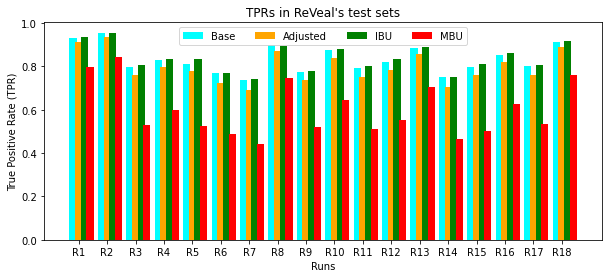

In [207]:
x = np.arange(18)
base = correctness_WNA
adjusted = correctness_adjusted_WNA
atomic = correctness_adjusted_atomic_WNA
complex_vul = correctness_adjusted_complex_WNA
fig = plt.figure(figsize = (10, 4))
plt.bar(x-0.2, base, width, color='cyan')
plt.bar(x, adjusted, width, color='orange')
plt.bar(x+0.2, atomic, width, color='green')
plt.bar(x+0.4, complex_vul, width, color='red')
plt.xticks(x, ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18'])
plt.xlabel("Runs")
plt.ylabel("True Positive Rate (TPR)")
plt.title("TPRs in ReVeal's test sets")
plt.legend(["Base", "Adjusted", "IBU", "MBU"], ncol=4)

plt.savefig("../PaperWriting/Figures/ReVeal/TPR-test-sets.png", dpi=500)
plt.show()

In [62]:
statistics.median(f for f in correctness_adjusted_complex if f != "N/A")
statistics.mean(f for f in correctness_adjusted_complex if f != "N/A")
statistics.stdev(f for f in correctness_adjusted_complex if f != "N/A")

0.12262463142512815